In [3]:
!ls

Untitled.ipynb	ondemand  scratch


In [9]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import platform
import sys
import subprocess
import shlex
import json
import re

In [8]:
"""
detect_system_accelerators.py

Purpose:
  - Print a clear summary of CPU and GPU information detected on the current machine.
  - Return a `system_info` dictionary containing structured info.

Notes:
  - Some parts use optional packages. The script will try them if installed, otherwise fall back
    to system commands where possible.
  - If you want more detailed output from optional packages, install them:
      pip install py-cpuinfo psutil GPUtil nvidia-ml-py3 torch tensorflow
"""

def safe_call(cmd):
    """Run command and return stdout (str) or None on error."""
    try:
        out = subprocess.check_output(shlex.split(cmd), stderr=subprocess.STDOUT, universal_newlines=True)
        return out.strip()
    except Exception:
        return None

# ---------------------
# CPU info
# ---------------------
def get_cpu_info():
    """Try multiple methods to get detailed CPU info."""
    info = {}
    info['platform'] = platform.platform()
    info['system'] = platform.system()
    info['machine'] = platform.machine()
    info['processor'] = platform.processor() or None

    # psutil for counts (optional)
    try:
        import psutil
        info['logical_cores'] = psutil.cpu_count(logical=True)
        info['physical_cores'] = psutil.cpu_count(logical=False)
        try:
            info['cpu_freq_mhz'] = psutil.cpu_freq().max if psutil.cpu_freq() else None
        except Exception:
            info['cpu_freq_mhz'] = None
    except Exception:
        info['logical_cores'] = None
        info['physical_cores'] = None
        info['cpu_freq_mhz'] = None

    # py-cpuinfo for human-readable name (optional)
    try:
        import cpuinfo
        ci = cpuinfo.get_cpu_info()
        # vendor_id, brand_raw, hz_advertised_friendly etc
        info['cpu_brand_raw'] = ci.get('brand_raw') or ci.get('brand') or None
        info['cpu_arch'] = ci.get('arch') or None
        info['bits'] = ci.get('bits') or None
    except Exception:
        # fallback to lscpu (Linux) or sysctl (mac), or wmic (Windows)
        info.setdefault('cpu_brand_raw', None)
        info.setdefault('cpu_arch', None)
        info.setdefault('bits', None)

        if info['system'] == 'Linux':
            out = safe_call("lscpu")
            if out:
                # parse some fields
                for line in out.splitlines():
                    if ':' not in line:
                        continue
                    k, v = [x.strip() for x in line.split(':', 1)]
                    if k == "Model name":
                        info['cpu_brand_raw'] = info['cpu_brand_raw'] or v
                    if k == "Architecture":
                        info['cpu_arch'] = info['cpu_arch'] or v
                    if k == "CPU op-mode(s)":
                        info['bits'] = info['bits'] or v
        elif info['system'] == 'Darwin':  # macOS
            out = safe_call("sysctl -n machdep.cpu.brand_string")
            if out:
                info['cpu_brand_raw'] = info['cpu_brand_raw'] or out
            out2 = safe_call("uname -m")
            if out2:
                info['cpu_arch'] = info['cpu_arch'] or out2
        elif info['system'] == 'Windows':
            out = safe_call("wmic cpu get Name,NumberOfCores,NumberOfLogicalProcessors /format:list")
            if out:
                for line in out.splitlines():
                    if '=' not in line:
                        continue
                    k, v = line.split('=', 1)
                    if k.strip() == 'Name' and v.strip():
                        info['cpu_brand_raw'] = info['cpu_brand_raw'] or v.strip()
                    if k.strip() == 'NumberOfCores':
                        try:
                            info['physical_cores'] = info['physical_cores'] or int(v.strip())
                        except Exception:
                            pass
                    if k.strip() == 'NumberOfLogicalProcessors':
                        try:
                            info['logical_cores'] = info['logical_cores'] or int(v.strip())
                        except Exception:
                            pass

    return info

# ---------------------
# GPU info
# ---------------------
def get_gpu_info():
    """
    Attempt to detect GPUs with multiple fallbacks:
      1) PyTorch (torch.cuda)
      2) TensorFlow
      3) NVIDIA NVML (pynvml)
      4) nvidia-smi command
      5) GPUtil package
      6) OS-level queries (lspci / wmic / system_profiler)
    Returns a list of GPU dicts or [] if none found.
    """
    gpus = []

    # 1) PyTorch
    try:
        import torch
        if torch.cuda.is_available():
            count = torch.cuda.device_count()
            for i in range(count):
                props = torch.cuda.get_device_properties(i)
                gpus.append({
                    "provider": "pytorch",
                    "index": i,
                    "name": str(props.name),
                    "total_memory_MB": int(props.total_memory / 1024 / 1024) if hasattr(props, "total_memory") else None,
                    "capability": f"{props.major}.{props.minor}" if hasattr(props, "major") else None,
                })
        # also check MPS (Apple Metal) for Apple silicon
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            gpus.append({"provider": "pytorch_mps", "name": "Apple MPS (Metal) available"})
    except Exception:
        pass

    # 2) TensorFlow
    try:
        import tensorflow as tf
        try:
            tf_gpus = tf.config.list_physical_devices('GPU')
            for idx, dev in enumerate(tf_gpus):
                gpus.append({
                    "provider": "tensorflow",
                    "index": idx,
                    "name": dev.name if hasattr(dev, "name") else str(dev),
                })
        except Exception:
            pass
    except Exception:
        pass

    # 3) NVIDIA NVML (pynvml)
    if not gpus:
        try:
            import pynvml
            pynvml.nvmlInit()
            device_count = pynvml.nvmlDeviceGetCount()
            for i in range(device_count):
                handle = pynvml.nvmlDeviceGetHandleByIndex(i)
                name = pynvml.nvmlDeviceGetName(handle).decode('utf-8') if isinstance(pynvml.nvmlDeviceGetName(handle), bytes) else pynvml.nvmlDeviceGetName(handle)
                mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                gpus.append({
                    "provider": "pynvml",
                    "index": i,
                    "name": name,
                    "total_memory_MB": int(mem_info.total / 1024 / 1024),
                })
            pynvml.nvmlShutdown()
        except Exception:
            pass

    # 4) nvidia-smi (CLI)
    if not gpus:
        out = safe_call("nvidia-smi --query-gpu=index,name,memory.total --format=csv,noheader,nounits")
        if out:
            for line in out.splitlines():
                parts = [p.strip() for p in line.split(',', 2)]
                if len(parts) >= 3:
                    idx, name, mem = parts[0], parts[1], parts[2]
                    try:
                        mem_mb = int(mem)
                    except Exception:
                        mem_mb = None
                    gpus.append({
                        "provider": "nvidia-smi",
                        "index": int(idx) if idx.isdigit() else idx,
                        "name": name,
                        "total_memory_MB": mem_mb,
                    })

    # 5) GPUtil (package)
    if not gpus:
        try:
            import GPUtil
            devs = GPUtil.getGPUs()
            for d in devs:
                gpus.append({
                    "provider": "gputil",
                    "index": int(d.id),
                    "name": d.name,
                    "total_memory_MB": getattr(d, 'memoryTotal', None),
                })
        except Exception:
            pass

    # 6) OS-level generic queries if still nothing found
    if not gpus:
        system = platform.system()
        if system == "Linux":
            # try lspci to look for VGA/3D controllers
            out = safe_call("lspci -vnn | grep -i -E 'vga|3d|display' -A 1")
            if out:
                # crude parsing
                lines = out.splitlines()
                for ln in lines:
                    # skip empty or lines with "Kernel driver"
                    if ln.strip() == "" or ln.strip().startswith("Kernel"):
                        continue
                    # capture vendor/name after device id
                    gpus.append({"provider": "lspci", "name": ln.strip()})
        elif system == "Darwin":
            out = safe_call("system_profiler SPDisplaysDataType -json")
            if out:
                try:
                    sp = json.loads(out)
                    displays = sp.get("SPDisplaysDataType", [])
                    for disp in displays:
                        name = disp.get("sppci_model") or disp.get("sppci_vram") or str(disp)
                        gpus.append({"provider": "system_profiler", "name": name, "details": disp})
                except Exception:
                    gpus.append({"provider": "system_profiler", "raw": out})
        elif system == "Windows":
            out = safe_call("wmic path win32_VideoController get name,AdapterRAM /format:list")
            if out:
                for chunk in out.split("\n\n"):
                    chunk = chunk.strip()
                    if not chunk:
                        continue
                    info = {}
                    for line in chunk.splitlines():
                        if '=' not in line:
                            continue
                        k, v = line.split('=', 1)
                        info[k.strip()] = v.strip()
                    if info:
                        name = info.get("Name") or "unknown"
                        ram = info.get("AdapterRAM")
                        mem_mb = None
                        try:
                            mem_mb = int(ram) // (1024**2) if ram else None
                        except Exception:
                            mem_mb = None
                        gpus.append({"provider": "wmic", "name": name, "total_memory_MB": mem_mb})

    # Deduplicate by name if multiple providers returned duplicates
    seen = set()
    clean = []
    for g in gpus:
        key = (str(g.get("name")), str(g.get("total_memory_MB")))
        if key in seen:
            continue
        seen.add(key)
        clean.append(g)

    return clean

# ---------------------
# Run and print a summary
# ---------------------
def main():
    cpu = get_cpu_info()
    gpus = get_gpu_info()

    system_info = {
        "cpu": cpu,
        "gpus": gpus
    }

    # Print a pretty summary
    print("\n=== CPU SUMMARY ===")
    print(f"System: {cpu.get('system')}  Platform: {cpu.get('platform')}")
    print(f"Machine: {cpu.get('machine')}")
    if cpu.get('cpu_brand_raw'):
        print(f"CPU: {cpu.get('cpu_brand_raw')}")
    elif cpu.get('processor'):
        print(f"CPU (processor): {cpu.get('processor')}")
    else:
        print("CPU: (brand unknown)")

    print(f"Physical cores: {cpu.get('physical_cores')}, Logical cores: {cpu.get('logical_cores')}")
    if cpu.get('cpu_freq_mhz'):
        print(f"Max frequency (MHz): {cpu.get('cpu_freq_mhz')}")
    if cpu.get('cpu_arch'):
        print(f"Architecture: {cpu.get('cpu_arch')}")
    if cpu.get('bits'):
        print(f"Bits / op-mode: {cpu.get('bits')}")

    print("\n=== GPU SUMMARY ===")
    if not gpus:
        print("No GPUs detected by the probes (PyTorch / TensorFlow / nvml / nvidia-smi / GPUtil / OS queries).")
        print("If you expect a GPU (NVIDIA/AMD/Apple), consider installing one of the optional packages:")
        print("  pip install torch tensorflow pynvml GPUtil py-cpuinfo psutil")
    else:
        for idx, g in enumerate(gpus):
            print(f"GPU #{idx}: provider={g.get('provider')}, name={g.get('name')}, total_memory_MB={g.get('total_memory_MB', 'unknown')}")

    # Also print JSON for programmatic consumption
    print("\n=== JSON OUTPUT ===")
    print(json.dumps(system_info, indent=2))

    return system_info

if __name__ == "__main__":
    info = main()



=== CPU SUMMARY ===
System: Linux  Platform: Linux-5.14.0-503.40.1.el9_5.x86_64-x86_64-with-glibc2.34
Machine: x86_64
CPU: Intel(R) Xeon(R) Gold 6226 CPU @ 2.70GHz
Physical cores: 24, Logical cores: 24
Max frequency (MHz): 2700.0
Architecture: x86_64
Bits / op-mode: 32-bit, 64-bit

=== GPU SUMMARY ===
No GPUs detected by the probes (PyTorch / TensorFlow / nvml / nvidia-smi / GPUtil / OS queries).
If you expect a GPU (NVIDIA/AMD/Apple), consider installing one of the optional packages:
  pip install torch tensorflow pynvml GPUtil py-cpuinfo psutil

=== JSON OUTPUT ===
{
  "cpu": {
    "platform": "Linux-5.14.0-503.40.1.el9_5.x86_64-x86_64-with-glibc2.34",
    "system": "Linux",
    "machine": "x86_64",
    "processor": "x86_64",
    "logical_cores": 24,
    "physical_cores": 24,
    "cpu_freq_mhz": 2700.0,
    "cpu_brand_raw": "Intel(R) Xeon(R) Gold 6226 CPU @ 2.70GHz",
    "cpu_arch": "x86_64",
    "bits": "32-bit, 64-bit"
  },
  "gpus": []
}


Scanning base directory: scratch/stonemt_cameratrap/Camera Trap Photos
Found 56472 image files in total (restricted to allowed years & SM_1..SM_5).

Total images per camera (allowed years):
camera_trap
SM_2    23949
SM_1    19954
SM_3     6247
SM_4     3524
SM_5     2798

Total images per year (allowed years):
year
2022    19091
2023    22965
2024     9766
2025     4650


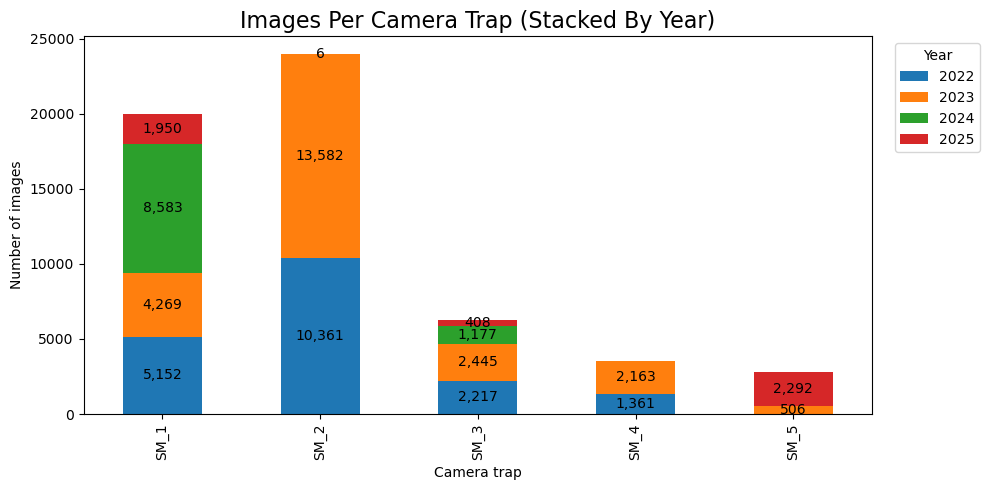

Saved: ondemand/Results/EDA/images_per_camera_by_year.png


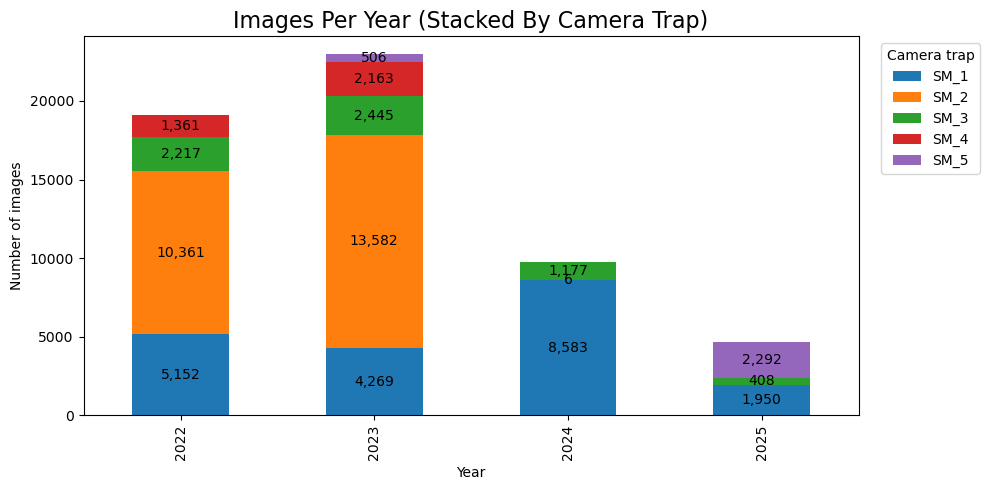

Saved: ondemand/Results/EDA/images_per_year_by_camera.png


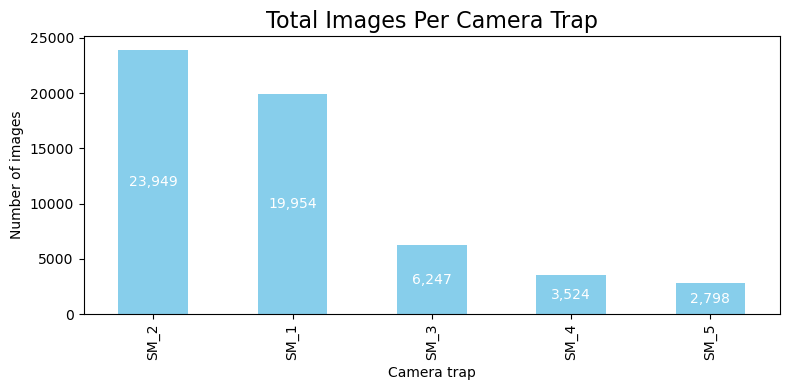

Saved: ondemand/Results/EDA/total_images_per_camera.png


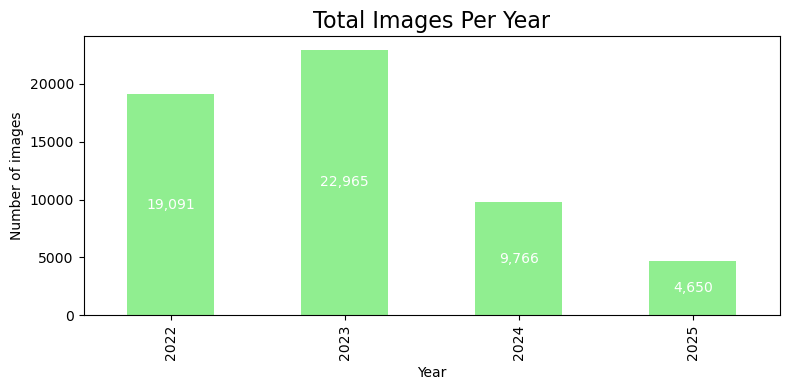

Saved: ondemand/Results/EDA/total_images_per_year.png


In [ ]:
"""
Camera-trap image summary (restricted years + stacked plots + labeled/condensed images)

Behavior:
 - Scans BASE_DIR for camera folders exactly named SM_1 .. SM_5
 - Within each camera folder, only processes subfolders whose name contains one of:
       2022, 2023, 2024, 2025  (e.g., "2024", "2024 (1)", "photos_2023" are accepted)
 - Counts image files (common extensions) under the accepted year folders (including deeper date folders)
 - Produces stacked column charts with data labels and saves them to ondemand/Results/EDA

Requirements:
 - pandas, matplotlib
 - Run in your Python environment that has access to your file system.
"""

from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Configuration
# -------------------------
BASE_DIR = Path("scratch/stonemt_cameratrap/Camera Trap Photos")
CAMERA_NAMES = [f"SM_{i}" for i in range(1, 6)]  # SM_1 .. SM_5
ALLOWED_YEARS = {"2022", "2023", "2024", "2025"}
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# Output paths and image settings
OUT_DIR = Path("ondemand/Results/EDA")
OUT_DIR.mkdir(parents=True, exist_ok=True)
DPI = 600
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 10
DATA_LABEL_FONTSIZE = 10
TICK_LABEL_FONTSIZE = 10

# -------------------------
# Helper functions
# -------------------------
def extract_year_from_string(s: str):
    """
    Extract the first '20xx' substring from a folder name.
    Returns the 4-digit year string (e.g. '2024') or None if not found.
    """
    m = re.search(r"(20\d{2})", s)
    return m.group(1) if m else None

def is_image_file(p: Path):
    """Return True if p is a file with a known image extension."""
    return p.is_file() and p.suffix.lower() in ALLOWED_EXTS

def add_data_labels_to_stacked_bars(ax):
    """
    Add comma-separated data labels to each segment of a stacked bar chart.

    For each Rectangle in ax.patches (matplotlib BarContainer rectangles),
    we compute the vertical center of the segment and place the formatted label,
    but only for segments with non-zero height.
    """
    for rect in ax.patches:
        height = rect.get_height()
        if height <= 0:
            continue
        x = rect.get_x() + rect.get_width() / 2.0
        # y center of this segment: bottom + half height
        y = rect.get_y() + height / 2.0
        label = f"{int(round(height)):,}"
        ax.text(x, y, label, ha="center", va="center", fontsize=DATA_LABEL_FONTSIZE)

# -------------------------
# Scan and collect records
# -------------------------
def collect_image_records(base_dir: Path):
    """
    Collect image records only from camera folders SM_1..SM_5 and
    only from year subfolders that contain allowed years.
    Returns list of dicts: {"camera_trap": ..., "year": ..., "file_path": ...}
    """
    records = []

    if not base_dir.exists():
        raise FileNotFoundError(f"Base directory does not exist: {base_dir}")

    for cam_name in CAMERA_NAMES:
        cam_dir = base_dir / cam_name
        if not cam_dir.exists() or not cam_dir.is_dir():
            # skip missing camera folders silently
            continue

        # iterate immediate children of camera directory (expected year folders)
        for child in sorted([c for c in cam_dir.iterdir() if c.is_dir()]):
            year_candidate = extract_year_from_string(child.name)
            if year_candidate is None or year_candidate not in ALLOWED_YEARS:
                # skip folders that do not include an allowed year substring
                continue

            # Walk all files under this year folder and count accepted image files
            for img in child.rglob("*"):
                if not is_image_file(img):
                    continue
                records.append({
                    "camera_trap": cam_name,
                    "year": year_candidate,
                    "file_path": str(img),
                })

    return records

# -------------------------
# Summarize and plot (stacked charts)
# -------------------------
def summarize_and_save_plots(records):
    """
    Build DataFrame, compute pivot tables, and create stacked column charts:
      1) Images per camera (stacked by year)  -> saved as images_per_camera_by_year.png
      2) Images per year (stacked by camera)  -> saved as images_per_year_by_camera.png

    All charts include data labels and saved to OUT_DIR with DPI and tight layout.
    """
    if len(records) == 0:
        print("No image records found for allowed years. Exiting.")
        return

    df = pd.DataFrame(records)
    df["count"] = 1

    # pivot: camera x year (rows camera, columns years)
    pivot_cam_year = df.pivot_table(
        index="camera_trap", columns="year", values="count", aggfunc="sum", fill_value=0
    ).sort_index()

    # Ensure columns ordered by ALLOWED_YEARS ascending
    col_order = sorted(list(ALLOWED_YEARS))
    # keep only columns that exist in the pivot (some years may be missing)
    col_order = [c for c in col_order if c in pivot_cam_year.columns]
    pivot_cam_year = pivot_cam_year[col_order]

    # pivot transposed: year x camera
    pivot_year_cam = pivot_cam_year.T  # now rows=year, columns=camera

    # Print basic summaries
    total_by_camera = pivot_cam_year.sum(axis=1).sort_values(ascending=False)
    total_by_year = pivot_year_cam.sum(axis=1).sort_index()
    print("\nTotal images per camera (allowed years):")
    print(total_by_camera.to_string())
    print("\nTotal images per year (allowed years):")
    print(total_by_year.to_string())

    # Save CSVs for record
    pivot_cam_year.to_csv(OUT_DIR / "camera_by_year_counts.csv")
    pivot_year_cam.to_csv(OUT_DIR / "year_by_camera_counts.csv")

    # --- Plot A: Images per camera (stacked by year) ---
    fig, ax = plt.subplots(figsize=(10, 5))  # condensed but readable
    pivot_cam_year.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title("Images Per Camera Trap (Stacked By Year)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Camera trap", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    add_data_labels_to_stacked_bars(ax)
    ax.legend(title="Year", fontsize=TICK_LABEL_FONTSIZE, title_fontsize=TICK_LABEL_FONTSIZE, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    out_path = OUT_DIR / "images_per_camera_by_year.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot B: Images per year (stacked by camera) ---
    fig, ax = plt.subplots(figsize=(10, 5))
    # pivot_year_cam rows=year, cols=camera -> stacked bars where each bar is a year and segments are cameras
    pivot_year_cam.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title("Images Per Year (Stacked By Camera Trap)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    add_data_labels_to_stacked_bars(ax)
    ax.legend(title="Camera trap", fontsize=TICK_LABEL_FONTSIZE, title_fontsize=TICK_LABEL_FONTSIZE, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    out_path = OUT_DIR / "images_per_year_by_camera.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot C: Total images per camera (single bar, labels inside) ---
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = total_by_camera.plot(kind="bar", color="blue", ax=ax)
    ax.set_title("Total Images Per Camera Trap", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Camera trap", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)

    # labels inside bar
    for i, v in enumerate(total_by_camera):
        ax.text(i, v/2, f"{int(v):,}", ha="center", va="center",
                fontsize=DATA_LABEL_FONTSIZE, color="white", rotation=0)

    plt.tight_layout()
    out_path = OUT_DIR / "total_images_per_camera.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

    # --- Plot D: Total images per year (single bar, labels inside) ---
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = total_by_year.plot(kind="bar", color="green", ax=ax)
    ax.set_title("Total Images Per Year", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Year", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Number of images", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)

    for i, v in enumerate(total_by_year):
        ax.text(i, v/2, f"{int(v):,}", ha="center", va="center",
                fontsize=DATA_LABEL_FONTSIZE, color="white", rotation=0)

    plt.tight_layout()
    out_path = OUT_DIR / "total_images_per_year.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")
    
    # --- Plot E: Histogram of image dimensions ---
    from PIL import Image

    # get width and height for each image
    dims = []
    for fp in df["file_path"]:
        try:
            with Image.open(fp) as im:
                dims.append(im.size)  # (width, height)
        except Exception:
            dims.append((None, None))

    df["width"], df["height"] = zip(*dims)

    # plot histogram of widths and heights
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist([df["width"].dropna(), df["height"].dropna()],
            bins=30, label=["Width", "Height"], alpha=0.7)
    ax.set_title("Histogram of Image Dimensions (pixels)", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Pixels", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel("Count", fontsize=AXIS_LABEL_FONTSIZE)
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    ax.legend(fontsize=TICK_LABEL_FONTSIZE)

    out_path = OUT_DIR / "image_dimensions_histogram.png"
    fig.savefig(out_path, dpi=DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path}")

# -------------------------
# Entrypoint
# -------------------------
def main():
    print("Scanning base directory:", BASE_DIR)
    records = collect_image_records(BASE_DIR)
    print(f"Found {len(records)} image files in total (restricted to allowed years & SM_1..SM_5).")
    summarize_and_save_plots(records)

if __name__ == "__main__":
    main()
